## Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# CARICAMENTO E PULIZIA DATI
df = pd.read_excel('Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')


In [ ]:
# Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [ ]:
df['Data'].max()


In [ ]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]
# Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 24   # lunghezza della sequenza di input (es. 24 ore)
label_width = 12   # lunghezza della sequenza target (predizione per le prossime 12 ore)
shift       = 24   # gap fra input e target 

total_window_size = input_width + shift  # lunghezza totale della finestra

Definizione delle funzioni e delle finestre di windowing

In [ ]:
def make_dataset(data, input_width, label_width, shift, batch_size, target_col="Potenza Uffici [W]"):
    # Converte il DataFrame in array numpy
    data_array = np.array(data, dtype=np.float32)
    total_window_size = input_width + shift
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    # Ottieni l'indice della colonna target
    target_col_index = data.columns.get_loc(target_col)
    
    def split_window(window):
        inputs = window[:, :input_width, :]
        # Seleziona solo la colonna target per le etichette:
        labels = window[:, input_width:input_width+label_width, target_col_index]
        # labels avrà forma (batch, label_width)
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds

def create_sequences_df(df, input_width=24, out_steps=24, target_col="Potenza Uffici [W]"):
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

# Il modello, nel build_model, ha un output di 12 unità, quindi ora y_trainval ha shape (n_samples, 12)
def build_model(input_shape, lstm_units=64, dense_units=12, dropout_rate=0.0, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model





Grid Search del modello di previsione degli uffici per 12 ore

In [ ]:


# Creazione delle sequenze per la grid search
X_train_uff, y_train_uff = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Potenza Uffici [W]")
X_val_uff,   y_val_uff   = create_sequences_df(val_data,   input_width=24, out_steps=12, target_col="Potenza Uffici [W]")

X_trainval_uff = np.concatenate([X_train_uff, X_val_uff], axis=0)
y_trainval_uff = np.concatenate([y_train_uff, y_val_uff], axis=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Grid search manuale
param_grid = {
    "lstm_units": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

# Genera tutte le combinazioni di parametri
keys_uff = param_grid.keys()
values_uff = param_grid.values()
param_combinations = [dict(zip(keys_uff, combo)) for combo in itertools.product(*values_uff)]

best_score_uff = -np.inf
best_params_uff = None
input_shape_uff = (X_trainval_uff.shape[1], X_trainval_uff.shape[2])  # Forma dell'input

for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_uff,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=12
        )
        
        history = model.fit(
            X_trainval_uff, y_trainval_uff,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  
            verbose=2
        )
        
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  
        
        if current_score > best_score_uff:
            best_score_uff = current_score
            best_params_uff = params
            print(f"Nuovo miglior punteggio: {best_score_uff:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri:", best_params_uff)
print("Miglior punteggio (neg_MSE):", best_score_uff)


Grid Search per il modello di previsione degli uffici autoregressivo di 1 h

In [ ]:
# Creazione delle sequenze per la grid search
X_train_uff_autoreg, y_train_uff_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Potenza Uffici [W]")
X_val_uff_autoreg,   y_val_uff_autoreg   = create_sequences_df(val_data,   input_width=24, out_steps=1, target_col="Potenza Uffici [W]")

X_trainval_uff_autoreg = np.concatenate([X_train_uff_autoreg, X_val_uff_autoreg], axis=0)
y_trainval_uff_autoreg = np.concatenate([y_train_uff_autoreg, y_val_uff_autoreg], axis=0)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Grid search manuale
param_grid = {
    "lstm_units": [32, 64, 128],
    "dropout_rate": [0.0, 0.2],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [16, 32, 64],
    "epochs": [100]  
}

# Genera tutte le combinazioni di parametri
keys_uff_autoreg = param_grid.keys()
values_uff_autoreg = param_grid.values()
param_combinations = [dict(zip(keys_uff_autoreg, combo)) for combo in itertools.product(*values_uff_autoreg)]

best_score_uff_autoreg = -np.inf
best_params_uff_autoreg = None
input_shape_uff_autoreg = (X_trainval_uff_autoreg.shape[1], X_trainval_uff_autoreg.shape[2])  # Forma dell'input

for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_uff_autoreg,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=1
        )
        
        history = model.fit(
            X_trainval_uff_autoreg, y_trainval_uff_autoreg,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  
            verbose=2
        )
        
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_uff_autoreg:
            best_score_uff_autoreg = current_score
            best_params_uff_autoreg = params
            print(f"Nuovo miglior punteggio: {best_score_uff_autoreg:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri:", best_params_uff_autoreg)
print("Miglior punteggio (neg_MSE):", best_score_uff_autoreg)

Grid search per il modello di previsione di 12 ore dell'irraggiamento

In [ ]:

# Creazione delle sequenze per la grid search
X_train_irr, y_train_irr = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")
X_val_irr, y_val_irr   = create_sequences_df(val_data,   input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")

X_trainval_irr = np.concatenate([X_train_irr, X_val_irr], axis=0)
y_trainval_irr = np.concatenate([y_train_irr, y_val_irr], axis=0)

# Genera tutte le combinazioni di parametri
keys_irr = param_grid.keys()
values_irr = param_grid.values()
param_combinations = [dict(zip(keys_irr, combo)) for combo in itertools.product(*values_irr)]

best_score_irr = -np.inf
best_params_irr = None
input_shape_irr = (X_trainval_irr.shape[1], X_trainval_irr.shape[2])  # Forma dell'input
print("GridSearch per il modello dell'irraggiamento")
for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_irr,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=12
        )
        
        history = model.fit(
            X_trainval_irr, y_trainval_irr,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  
            verbose=2,
            n_jobs=-1
        )
        
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_irr:
            best_score_irr = current_score
            best_params_irr = params
            print(f"Nuovo miglior punteggio: {best_score_irr:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri irraggiamento:", best_params_irr)
print("Miglior punteggio (neg_MSE):", best_score_irr)

Grid search per il modello di previsione di un ora dell'irraggiamento

In [ ]:
# Creazione delle sequenze per la grid search
X_train_irr_autoreg, y_train_irr_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")
X_val_irr_autoreg, y_val_irr_autoreg   = create_sequences_df(val_data,   input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")

X_trainval_irr_autoreg = np.concatenate([X_train_irr_autoreg, X_val_irr_autoreg], axis=0)
y_trainval_irr_autoreg = np.concatenate([y_train_irr_autoreg, y_val_irr_autoreg], axis=0)

# Genera tutte le combinazioni di parametri
keys_irr_autoreg = param_grid.keys()
values_irr_autoreg = param_grid.values()
param_combinations = [dict(zip(keys_irr_autoreg, combo)) for combo in itertools.product(*values_irr_autoreg)]

best_score_irr_autoreg = -np.inf
best_params_irr_autoreg = None
input_shape_irr_autoreg = (X_trainval_irr_autoreg.shape[1], X_trainval_irr_autoreg.shape[2])  # Forma dell'input
print("GridSearch per il modello dell'irraggiamento")
for params in param_combinations:
    print(f"\nTesting parameters: {params}")
    
    try:
        # Costruisci e allena il modello
        model = build_model(
            input_shape=input_shape_irr_autoreg,
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            dense_units=1
        )
        
        history = model.fit(
            X_trainval_irr_autoreg, y_trainval_irr_autoreg,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=[early_stopping],
            validation_split=0.2,  
            verbose=2
        )
        
        val_loss = np.min(history.history['val_loss']) 
        current_score = -val_loss  # Negativo per mantenere la stessa metrica
        
        if current_score > best_score_irr_autoreg:
            best_score_irr_autoreg = current_score
            best_params_irr_autoreg = params
            print(f"Nuovo miglior punteggio: {best_score_irr_autoreg:.4f}")
            
    except Exception as e:
        print(f"Fallito con parametri {params}: {str(e)}")
        continue

print("\nMigliori iperparametri irraggiamento:", best_params_irr_autoreg)
print("Miglior punteggio (neg_MSE):", best_score_irr_autoreg)

## Addestramento dei Modelli
**Modello 12 ore uffici**


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Costruzione del modello finale con i migliori iperparametri
final_model_uff = build_model(input_shape=input_shape_uff,
    lstm_units=best_params_uff["lstm_units"],
    dropout_rate=best_params_uff["dropout_rate"],
    learning_rate=best_params_uff["learning_rate"],
    dense_units=12  # questo parametro corrisponde al numero di uscite e quindi alle ore che devono essere predette
)
label_width_uff = 12

train_ds_uff = make_dataset(train_data, input_width, label_width, shift, best_params_uff["batch_size"])
val_ds_uff   = make_dataset(val_data, input_width, label_width, shift, best_params_uff["batch_size"])
test_ds_uff  = make_dataset(test_data, input_width, label_width, shift, best_params_uff["batch_size"])

# Addestramento del modello finale
final_model_uff.fit(
    train_ds_uff,
    epochs=best_params_uff["epochs"]+300,
    validation_data=val_ds_uff,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff, test_mae_uff = final_model_uff.evaluate(test_ds_uff, verbose=1)
print("Test loss:", test_loss_uff, "Test MAE:", test_mae_uff)

# salvo il modello addestrato
final_model_uff.save("final_model_uff.h5")

**Modello 1 ora uffici**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Costruzione del modello finale con i migliori iperparametri
final_model_uff_autoreg = build_model(input_shape=input_shape_uff_autoreg,
    lstm_units=best_params_uff_autoreg["lstm_units"],
    dropout_rate=best_params_uff_autoreg["dropout_rate"],
    learning_rate=best_params_uff_autoreg["learning_rate"],
    dense_units=1
)
label_width_uff_autoreg = 1
train_ds_uff_autoreg = make_dataset(train_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
val_ds_uff_autoreg   = make_dataset(val_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
test_ds_uff_autoreg  = make_dataset(test_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])

# Addestramento del modello finale
final_model_uff_autoreg.fit(
    train_ds_uff_autoreg,
    epochs=best_params_uff_autoreg["epochs"]+300,
    validation_data=val_ds_uff_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff_autoreg, test_mae_uff_autoreg = final_model_uff_autoreg.evaluate(test_ds_uff_autoreg, verbose=1)
print("Test loss:", test_loss_uff_autoreg, "Test MAE:", test_mae_uff_autoreg)


# salvo il modello addestrato
final_model_uff_autoreg.save("final_model_uff_autoreg.h5")

**Modello 12 ore irraggiamento**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Costruzione del modello finale con i migliori iperparametri
final_model_irr = build_model(input_shape=input_shape_irr,
    lstm_units=best_params_irr["lstm_units"],
    dropout_rate=best_params_irr["dropout_rate"],
    learning_rate=best_params_irr["learning_rate"],
    dense_units=12
)
label_width_irr = 12
train_ds_irr = make_dataset(train_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr   = make_dataset(val_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr  = make_dataset(test_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")

# Addestramento del modello finale
final_model_irr.fit(
    train_ds_irr,
    epochs=best_params_irr["epochs"]+300,
    validation_data=val_ds_irr,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr, test_mae_irr = final_model_irr.evaluate(test_ds_irr, verbose=1)
print("Test loss:", test_loss_irr, "Test MAE:", test_mae_irr)


# salvo il modello addestrato
final_model_irr.save("final_model_irr.h5")

**Modello 1 ora irraggiamento**


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Costruzione del modello finale con i migliori iperparametri
final_model_irr_autoreg = build_model(input_shape=input_shape_irr_autoreg,
    lstm_units=best_params_irr_autoreg["lstm_units"],
    dropout_rate=best_params_irr_autoreg["dropout_rate"],
    learning_rate=best_params_irr_autoreg["learning_rate"],
    dense_units=1
)
label_width_irr_autoreg = 1
train_ds_irr_autoreg = make_dataset(train_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr_autoreg   = make_dataset(val_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr_autoreg  = make_dataset(test_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")

#  Addestramento del modello finale
final_model_irr_autoreg.fit(
    train_ds_irr_autoreg,
    epochs=best_params_irr_autoreg["epochs"]+300,
    validation_data=val_ds_irr_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr_autoreg, test_mae_irr_autoreg = final_model_irr_autoreg.evaluate(test_ds_irr_autoreg, verbose=1)
print("Test loss:", test_loss_irr_autoreg, "Test MAE:", test_mae_irr_autoreg)


# salvo il modello addestrato
final_model_irr_autoreg.save("final_model_irr_autoreg.h5")

**Creazione del dataset con i dati reali per i successivi due mesi**

In [ ]:
data2 = pd.read_excel('/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/Dataset-Project-Deep-Learning-SMRES-Scartati.xlsx')
dataset_filtered = data2[data2['Data'] <= '2022-09-01']


In [ ]:
# Conversione della colonna Data in formato datetime
dataset_filtered['Data'] = pd.to_datetime(dataset_filtered['Data'], format='%d.%m.%Y %H:%M:%S')

# Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
dataset_filtered['Ora'] = dataset_filtered['Ora'].str.split(':').str[0].astype(int)

# Calcolo delle trasformazioni orarie
dataset_filtered['Day_sin'] = np.sin(2 * np.pi * dataset_filtered['Ora'] / 24)
dataset_filtered['Day_cos'] = np.cos(2 * np.pi * dataset_filtered['Ora'] / 24)

# Costruzione della colonna date_time combinando la data (senza orario) e l'ora
dataset_filtered['date_time'] = pd.to_datetime(
    dataset_filtered['Data'].dt.strftime('%Y-%m-%d') + ' ' + dataset_filtered['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = dataset_filtered['date_time'].map(pd.Timestamp.timestamp)

In [ ]:
dataset_filtered.info()

In [ ]:
from tensorflow.keras.models import load_model

# Carica i modelli salvati
final_model_irr_autoreg = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/pretrained_models/final_model_irr_autoreg.h5")
final_model_irr         = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/pretrained_models/final_model_irr.h5")
final_model_uff_autoreg = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/pretrained_models/final_model_uff_autoreg.h5")
final_model_uff         = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/pretrained_models/final_model_uff.h5")

In [ ]:
# Seleziona il periodo di valutazione: ultimi 2 mesi del dataset
max_date = dataset_filtered["Data"].max()
eval_start_date = max_date - pd.DateOffset(months=2)
evaluation_data = dataset_filtered[dataset_filtered["Data"] >= eval_start_date].copy()
print("Periodo di valutazione da", evaluation_data["Data"].min(), "a", evaluation_data["Data"].max())


features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]",
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]

evaluation_data_std = evaluation_data.copy()
evaluation_data_std[features] = (evaluation_data_std[features] - train_mean[features]) / train_std[features]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




#  Impostazioni generali
input_width = 24     # 24 ore di input
forecast_steps = 100 # Numero di passi di forecasting autoregressivo

# La finestra di input standardizzata viene presa dalle righe subito precedenti al periodo forecast.
current_window_common = evaluation_data_std.iloc[-(input_width + forecast_steps):-forecast_steps][features].values.copy()

gt_std_dict = {}
for target in ["Potenza Uffici [W]", "Irraggiamento [kWh/m2]"]:
    gt_std_dict[target] = (evaluation_data.iloc[-forecast_steps:][target] - train_mean[target]) / train_std[target]

# Definizione dei modelli e informazioni
models_info = [
    {"name": "Uffici Autoreg", "model": final_model_uff_autoreg, "target": "Potenza Uffici [W]"},
    {"name": "Uffici",         "model": final_model_uff,         "target": "Potenza Uffici [W]"},
    {"name": "Irraggiamento Autoreg", "model": final_model_irr_autoreg, "target": "Irraggiamento [kWh/m2]"},
    {"name": "Irraggiamento",         "model": final_model_irr,         "target": "Irraggiamento [kWh/m2]"}
]

#  Loop per ciascun modello: forecasting autoregressivo, metriche e salvataggio Excel
for m_info in models_info:
    model = m_info["model"]
    target = m_info["target"]
    model_name = m_info["name"]
    
    # Inizializza la finestra per il modello (copia della finestra comune, standardizzata)
    current_window = current_window_common.copy()
    forecast_std = []  # Salva le previsioni in scala standardizzata
    
    print(f"\n=== Autoregressive Forecast - {model_name} ===\n")
    for step in range(forecast_steps):
        print(f"Step {step+1} - Input window ({model_name}):")
        print(current_window)
        
        pred = model.predict(current_window.reshape(1, input_width, len(features)), verbose=0)
        predicted_std = pred[0, 0]
        print(f"Step {step+1} - Predicted value (standardizzata) ({model_name}): {predicted_std}\n")
        
        forecast_std.append(predicted_std)
        
        # Aggiorna la finestra: elimina la prima riga e aggiunge una nuova riga in coda,
        # sostituendo il valore della feature target con il valore predetto.
        new_row = current_window[-1].copy()
        target_index = features.index(target)
        new_row[target_index] = predicted_std
        current_window = np.vstack([current_window[1:], new_row])
    
    forecast_std = np.array(forecast_std)
    
    # Calcolo delle metriche (sul forecast standardizzato)
    gt_std = gt_std_dict[target]
    abs_errors = np.abs(forecast_std - gt_std)
    rmse_horizon = np.sqrt((forecast_std - gt_std)**2)  # per ogni punto, RMSE = |errore|
    global_mae = np.mean(abs_errors)
    global_rmse = np.mean(rmse_horizon)
    
    print(f"{model_name} Global MAE (standardizzata): {global_mae}")
    print(f"{model_name} Global RMSE (standardizzata): {global_rmse}\n")
    
    # Converti le previsioni in scala reale per il salvataggio.
    # NOTA: la ground truth in evaluation_data è già in scala reale.
    forecast_real = forecast_std * train_std[target] + train_mean[target]
    
    # Plot: Forecast vs Ground Truth (scala reale)
    time_axis = evaluation_data.iloc[-forecast_steps:]["date_time"]
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, evaluation_data.iloc[-forecast_steps:][target].values, label="Ground Truth", marker=".", markersize=3)
    plt.plot(time_axis, forecast_real, label="Forecast", linestyle="--", marker="x", markersize=3)
    plt.xlabel("Data")
    plt.ylabel(f"{target} (real scale)")
    plt.title(f"Forecast vs Ground Truth - {model_name}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot: Error Metrics vs Prediction Horizon (calcolati in scala standardizzata)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, forecast_steps+1), abs_errors, label="MAE (std)")
    plt.plot(range(1, forecast_steps+1), rmse_horizon, label="RMSE (std)")
    plt.xlabel("Prediction Horizon (hours)")
    plt.ylabel("Error (standardizzata)")
    plt.title(f"Error Metrics vs Prediction Horizon - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Il timestep parte da "2022-07-01 00:00:00" con frequenza oraria.
    time_range = pd.date_range(start="2022-07-01 00:00:00", periods=forecast_steps, freq="H")
    df_forecast = pd.DataFrame({"timestep": time_range, "forecast": forecast_real})
    
    filename = f"{model_name.replace(' ', '_').lower()}_forecast.xlsx"
    df_forecast.to_excel(filename, index=False)
    print(f"File Excel salvato per {model_name}: {filename}\n")

**NUOVI MODELLI STACKED RNN**


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
from tensorflow.keras.callbacks import EarlyStopping
import itertools

# CARICAMENTO E PULIZIA DATI
df = pd.read_excel('Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')


In [ ]:
# Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [ ]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]
# Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 24   # lunghezza della sequenza di input (es. 24 ore)
label_width = 12   # lunghezza della sequenza target (predizione per le prossime 12 ore)
shift       = 24   # gap fra input e target 

total_window_size = input_width + shift  # lunghezza totale della finestra

In [ ]:
def make_dataset(data, input_width, label_width, shift, batch_size, target_col="Potenza Uffici [W]"):
    # Converte il DataFrame in array numpy
    data_array = np.array(data, dtype=np.float32)
    total_window_size = input_width + shift
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data_array,
        targets=None,
        sequence_length=total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size
    )
    # Ottieni l'indice della colonna target
    target_col_index = data.columns.get_loc(target_col)
    
    def split_window(window):
        inputs = window[:, :input_width, :]
        # Seleziona solo la colonna target per le etichette:
        labels = window[:, input_width:input_width+label_width, target_col_index]
        # labels avrà forma (batch, label_width)
        return inputs, labels
    
    ds = ds.map(split_window)
    return ds

def create_sequences_df(df, input_width=24, out_steps=24, target_col="Potenza Uffici [W]"):
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    sequences = np.array(sequences)
    labels = np.array(labels)
    return sequences, labels

# Il modello, nel build_model, ha un output di 12 unità, quindi ora y_trainval ha shape (n_samples, 12)
def build_model(input_shape, lstm_units=64, dense_units=12, dropout_rate=0.0, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(lstm_units, dropout=dropout_rate),
        tf.keras.layers.Dense(dense_units)
    ])
    
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model





In [ ]:
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor  # Wrapper da scikeras
from sklearn.model_selection import GridSearchCV

# Funzione per costruire un modello GRU con un ulteriore layer GRU
def build_model_gru(input_shape, gru_units, dropout_rate, learning_rate, dense_units):
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        GRU(gru_units, dropout=dropout_rate, return_sequences=True, kernel_regularizer=l2(0.01)),
        GRU(gru_units, dropout=dropout_rate, return_sequences=True, kernel_regularizer=l2(0.01)),
        GRU(gru_units, dropout=dropout_rate, kernel_regularizer=l2(0.01)),  # ulteriore layer GRU
        Dense(dense_units)
    ])
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

In [ ]:
# Creazione delle sequenze per il target "Potenza Uffici [W]" con 12 output
X_train_uff, y_train_uff = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Potenza Uffici [W]")
X_val_uff,   y_val_uff   = create_sequences_df(val_data,   input_width=24, out_steps=12, target_col="Potenza Uffici [W]")
X_trainval_uff = np.concatenate([X_train_uff, X_val_uff], axis=0)
y_trainval_uff = np.concatenate([y_train_uff, y_val_uff], axis=0)
input_shape_uff = (X_trainval_uff.shape[1], X_trainval_uff.shape[2])

# Creazione delle sequenze per il target "Potenza Uffici [W]" con 1 output
X_train_uff_autoreg, y_train_uff_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Potenza Uffici [W]")
X_val_uff_autoreg,   y_val_uff_autoreg   = create_sequences_df(val_data,   input_width=24, out_steps=1, target_col="Potenza Uffici [W]")
X_trainval_uff_autoreg = np.concatenate([X_train_uff_autoreg, X_val_uff_autoreg], axis=0)
y_trainval_uff_autoreg = np.concatenate([y_train_uff_autoreg, y_val_uff_autoreg], axis=0)
input_shape_uff_autoreg = (X_trainval_uff_autoreg.shape[1], X_trainval_uff_autoreg.shape[2])

# Creazione delle sequenze per il target "Irraggiamento [kWh/m2]" con 12 output
X_train_irr, y_train_irr = create_sequences_df(train_data, input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")
X_val_irr, y_val_irr = create_sequences_df(val_data, input_width=24, out_steps=12, target_col="Irraggiamento [kWh/m2]")
X_trainval_irr = np.concatenate([X_train_irr, X_val_irr], axis=0)
y_trainval_irr = np.concatenate([y_train_irr, y_val_irr], axis=0)
input_shape_irr = (X_trainval_irr.shape[1], X_trainval_irr.shape[2])

# Creazione delle sequenze per il target "Irraggiamento [kWh/m2]" con 1 output
X_train_irr_autoreg, y_train_irr_autoreg = create_sequences_df(train_data, input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")
X_val_irr_autoreg, y_val_irr_autoreg = create_sequences_df(val_data, input_width=24, out_steps=1, target_col="Irraggiamento [kWh/m2]")
X_trainval_irr_autoreg = np.concatenate([X_train_irr_autoreg, X_val_irr_autoreg], axis=0)
y_trainval_irr_autoreg = np.concatenate([y_train_irr_autoreg, y_val_irr_autoreg], axis=0)
input_shape_irr_autoreg = (X_trainval_irr_autoreg.shape[1], X_trainval_irr_autoreg.shape[2])

In [ ]:


# Parametri della grid search
param_grid_gru = {
    "model__gru_units": [32, 64, 128],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [0.001, 0.0005],
    "model__dense_units": [12],  # per modelli multi-step (12 output) oppure [1] per autoregressivi
    "batch_size": [16, 32, 64],
    "epochs": [100]
}




# Funzione builder per "Uffici GRU" multi-step
def create_model_uff_gru(gru_units, dropout_rate, learning_rate, dense_units):
    return build_model_gru(
        input_shape=input_shape_uff,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        dense_units=dense_units   
    )

regressor_uff = KerasRegressor(model=create_model_uff_gru, verbose=0)
grid_search_uff = GridSearchCV(
    estimator=regressor_uff, 
    param_grid={
        "model__gru_units": param_grid_gru["model__gru_units"],
        "model__dropout_rate": param_grid_gru["model__dropout_rate"],
        "model__learning_rate": param_grid_gru["model__learning_rate"],
        "model__dense_units": [12],
        "batch_size": param_grid_gru["batch_size"],
        "epochs": param_grid_gru["epochs"]
    },
    n_jobs=-1,
    cv=3
)
grid_search_uff.fit(X_trainval_uff, y_trainval_uff)
print("Best score for Uffici GRU (multi-step):", grid_search_uff.best_score_)
print("Best parameters for Uffici GRU (multi-step):", grid_search_uff.best_params_)




# Funzione builder per "Uffici Autoreg GRU"
def create_model_uff_autoreg_gru(gru_units, dropout_rate, learning_rate, dense_units):
    return build_model_gru(
        input_shape=input_shape_uff_autoreg,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        dense_units=dense_units   # qui dense_units deve essere 1
    )

regressor_uff_autoreg = KerasRegressor(model=create_model_uff_autoreg_gru, verbose=0)
grid_search_uff_autoreg = GridSearchCV(
    estimator=regressor_uff_autoreg,
    param_grid={
        "model__gru_units": param_grid_gru["model__gru_units"],
        "model__dropout_rate": param_grid_gru["model__dropout_rate"],
        "model__learning_rate": param_grid_gru["model__learning_rate"],
        "model__dense_units": [1],
        "batch_size": param_grid_gru["batch_size"],
        "epochs": param_grid_gru["epochs"]
    },
    n_jobs=-1,
    cv=3
)
grid_search_uff_autoreg.fit(X_trainval_uff_autoreg, y_trainval_uff_autoreg)
print("Best score for Uffici Autoreg GRU:", grid_search_uff_autoreg.best_score_)
print("Best parameters for Uffici Autoreg GRU:", grid_search_uff_autoreg.best_params_)

# Grid Search per il modello "Irraggiamento GRU" (multi-step: out_steps = 12)



def create_model_irr_gru(gru_units, dropout_rate, learning_rate, dense_units):
    return build_model_gru(
        input_shape=input_shape_irr,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        dense_units=dense_units   # qui dense_units deve essere 12
    )

regressor_irr = KerasRegressor(model=create_model_irr_gru, verbose=0)
grid_search_irr = GridSearchCV(
    estimator=regressor_irr,
    param_grid={
        "model__gru_units": param_grid_gru["model__gru_units"],
        "model__dropout_rate": param_grid_gru["model__dropout_rate"],
        "model__learning_rate": param_grid_gru["model__learning_rate"],
        "model__dense_units": [12],
        "batch_size": param_grid_gru["batch_size"],
        "epochs": param_grid_gru["epochs"]
    },
    n_jobs=-1,
    cv=3
)
grid_search_irr.fit(X_trainval_irr, y_trainval_irr)
print("Best score for Irraggiamento GRU:", grid_search_irr.best_score_)
print("Best parameters for Irraggiamento GRU:", grid_search_irr.best_params_)

# Grid Search per il modello "Irraggiamento Autoreg GRU" (out_steps = 1)



def create_model_irr_autoreg_gru(gru_units, dropout_rate, learning_rate, dense_units):
    return build_model_gru(
        input_shape=input_shape_irr_autoreg,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        dense_units=dense_units   # qui dense_units deve essere 1
    )

regressor_irr_autoreg = KerasRegressor(model=create_model_irr_autoreg_gru, verbose=0)
grid_search_irr_autoreg = GridSearchCV(
    estimator=regressor_irr_autoreg,
    param_grid={
        "model__gru_units": param_grid_gru["model__gru_units"],
        "model__dropout_rate": param_grid_gru["model__dropout_rate"],
        "model__learning_rate": param_grid_gru["model__learning_rate"],
        "model__dense_units": [1],
        "batch_size": param_grid_gru["batch_size"],
        "epochs": param_grid_gru["epochs"]
    },
    n_jobs=-1,
    cv=3
)
grid_search_irr_autoreg.fit(X_trainval_irr_autoreg, y_trainval_irr_autoreg)
print("Best score for Irraggiamento Autoreg GRU:", grid_search_irr_autoreg.best_score_)
print("Best parameters for Irraggiamento Autoreg GRU:", grid_search_irr_autoreg.best_params_)

In [ ]:
import json

# Caricare il file JSON
with open("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/pretrained_models/best_params_gru.json", "r") as file:
    best_params_data = json.load(file)

# Estrarre i parametri
best_params_irr = best_params_data.get("irraggiamento_12h", {})
best_params_irr_autoreg = best_params_data.get("irraggiamento_1h", {})
best_params_uff_autoreg = best_params_data.get("uffici_1h", {})
best_params_uff = best_params_data.get("uffici_12h", {})

# Stampare per verifica
print("Best Params IRR:", best_params_irr)
print("Best Params IRR Autoreg:", best_params_irr_autoreg)
print("Best Params UFF Autoreg:", best_params_uff_autoreg)
print("Best Params UFF:", best_params_uff)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

final_model_irr_gru = build_model_gru(
    input_shape=input_shape_irr,
    gru_units=best_params_irr["model__gru_units"],  
    dropout_rate=best_params_irr["model__dropout_rate"],
    learning_rate=best_params_irr["model__learning_rate"],
    dense_units=12  # 12 uscite per 12 ore di predizione
)

label_width_irr = 12
train_ds_irr = make_dataset(train_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr   = make_dataset(val_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr  = make_dataset(test_data, input_width, label_width_irr, shift, best_params_irr["batch_size"], target_col="Irraggiamento [kWh/m2]")

final_model_irr_gru.fit(
    train_ds_irr,
    epochs=best_params_irr["epochs"] + 300,
    validation_data=val_ds_irr,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr, test_mae_irr = final_model_irr_gru.evaluate(test_ds_irr, verbose=1)
print("GRU Irraggiamento - Test loss:", test_loss_irr, "Test MAE:", test_mae_irr)
final_model_irr_gru.save("final_model_irr_gru.h5")

# Modello "Irraggiamento Autoreg" (predizione autoregressiva, 1 ora in avanti)
label_width_irr_autoreg = 1
final_model_irr_autoreg_gru = build_model_gru(
    input_shape=input_shape_irr_autoreg,
    gru_units=best_params_irr_autoreg["model__gru_units"],
    dropout_rate=best_params_irr_autoreg["model__dropout_rate"],
    learning_rate=best_params_irr_autoreg["model__learning_rate"],
    dense_units=1
)
train_ds_irr_autoreg = make_dataset(train_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
val_ds_irr_autoreg   = make_dataset(val_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")
test_ds_irr_autoreg  = make_dataset(test_data, input_width, label_width_irr_autoreg, shift, best_params_irr_autoreg["batch_size"], target_col="Irraggiamento [kWh/m2]")

final_model_irr_autoreg_gru.fit(
    train_ds_irr_autoreg,
    epochs=best_params_irr_autoreg["epochs"] + 300,
    validation_data=val_ds_irr_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_irr_autoreg, test_mae_irr_autoreg = final_model_irr_autoreg_gru.evaluate(test_ds_irr_autoreg, verbose=1)
print("GRU Irraggiamento Autoreg - Test loss:", test_loss_irr_autoreg, "Test MAE:", test_mae_irr_autoreg)
final_model_irr_autoreg_gru.save("final_model_irr_autoreg_gru.h5")


# Modello "Uffici" (predizione multi-step, 12 ore in avanti)
final_model_uff_gru = build_model_gru(
    input_shape=input_shape_uff,
    gru_units=best_params_uff["model__gru_units"],
    dropout_rate=best_params_uff["model__dropout_rate"],
    learning_rate=best_params_uff["model__learning_rate"],
    dense_units=12
)
label_width_uff = 12
train_ds_uff = make_dataset(train_data, input_width, label_width, shift, best_params_uff["batch_size"])  # target_col predefinito per "Uffici"
val_ds_uff   = make_dataset(val_data, input_width, label_width, shift, best_params_uff["batch_size"])
test_ds_uff  = make_dataset(test_data, input_width, label_width, shift, best_params_uff["batch_size"])

final_model_uff_gru.fit(
    train_ds_uff,
    epochs=best_params_uff["epochs"] + 300,
    validation_data=val_ds_uff,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff, test_mae_uff = final_model_uff_gru.evaluate(test_ds_uff, verbose=1)
print("GRU Uffici - Test loss:", test_loss_uff, "Test MAE:", test_mae_uff)
final_model_uff_gru.save("final_model_uff_gru.h5")

# Modello "Uffici Autoreg" (predizione autoregressiva, 1 ora in avanti)
final_model_uff_autoreg_gru = build_model_gru(
    input_shape=input_shape_uff_autoreg,
    gru_units=best_params_uff_autoreg["model__gru_units"],
    dropout_rate=best_params_uff_autoreg["model__dropout_rate"],
    learning_rate=best_params_uff_autoreg["model__learning_rate"],
    dense_units=1
)
label_width_uff_autoreg = 1
train_ds_uff_autoreg = make_dataset(train_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
val_ds_uff_autoreg   = make_dataset(val_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])
test_ds_uff_autoreg  = make_dataset(test_data, input_width, label_width_uff_autoreg, shift, best_params_uff_autoreg["batch_size"])

final_model_uff_autoreg_gru.fit(
    train_ds_uff_autoreg,
    epochs=best_params_uff_autoreg["epochs"] + 300,
    validation_data=val_ds_uff_autoreg,
    verbose=1,
    callbacks=[early_stopping]
)
test_loss_uff_autoreg, test_mae_uff_autoreg = final_model_uff_autoreg_gru.evaluate(test_ds_uff_autoreg, verbose=1)
print("GRU Uffici Autoreg - Test loss:", test_loss_uff_autoreg, "Test MAE:", test_mae_uff_autoreg)
final_model_uff_autoreg_gru.save("final_model_uff_autoreg_gru.h5")

In [ ]:
from tensorflow.keras.models import load_model

final_model_irr_autoreg_gru = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/final_model_irr_autoreg_gru.h5")
final_model_irr_gru         = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/final_model_irr_gru.h5")
final_model_uff_autoreg_gru = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/final_model_uff_autoreg_gru.h5")
final_model_uff_gru         = load_model("/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/final_model_uff_gru.h5")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as rd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor



features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]", 
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]
forecast_steps = 1440  # Numero di timesteps di forecast

import os
import random as rd

class Plotter:
    def __init__(self, real_values, forecasted_values, xlabel:str, ylabel:str, model_name:str, show_plot:bool, real_label='Real Values', forecasted_label='Forecasted Values'):
        self.real_values = real_values
        self.forecasted_values = forecasted_values
        self.real_label = real_label
        self.forecasted_label = forecasted_label
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.model_name = model_name
        self.show_plot = show_plot

    def test_plot(self, num_subplots=3):
        real_vals = np.array(self.real_values).squeeze()
        total_points = len(real_vals)
        if total_points < 24:
            raise ValueError("Not enough data points for plotting.")
        max_start = total_points - 24
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 3 * num_subplots))
        if num_subplots == 1:
            axes = [axes]
        for i in range(num_subplots):
            random_index = rd.randint(24, max_start)
            x_vals = np.arange(24)
            y_vals = real_vals[random_index:random_index+24]
            axes[i].plot(x_vals, y_vals, label='Data', color='blue', marker='.', linestyle='-')
            axes[i].set_title(f'{self.model_name} - Interval starting at index {random_index}')
            axes[i].set_xlabel(self.xlabel)
            axes[i].set_ylabel(self.ylabel)
            axes[i].legend(loc='upper right')
            axes[i].grid(True)
        plt.tight_layout()
        if not os.path.exists('./TimeSeries/plots'):
            os.makedirs('./TimeSeries/plots')
        plt.savefig(f'./TimeSeries/plots/test_predictions_{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()

    def points_plot(self, num_subplots=1, num_points=None):
        if num_points is None:
            num_points = len(self.real_values) // num_subplots
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots))
        if num_subplots == 1:
            axes = [axes]
        total_points = len(self.real_values)
        segment_length = total_points // num_subplots
        for i in range(num_subplots):
            start_idx = i * segment_length
            end_idx = start_idx + num_points
            axes[i].plot(self.real_values[start_idx:end_idx], label=self.real_label, color='blue')
            axes[i].plot(self.forecasted_values[start_idx:end_idx], label=self.forecasted_label, color='red', linestyle='--')
            axes[i].set_xlabel(self.xlabel)
            axes[i].set_ylabel(self.ylabel)
            axes[i].set_title(f'Real vs Forecasted Values (Segment {i+1}) - Model {self.model_name}')
            axes[i].legend(loc='upper right')
            axes[i].grid(True)
        plt.tight_layout()
        if not os.path.exists('./TimeSeries/plots'):
            os.makedirs('./TimeSeries/plots')
        plt.savefig(f'./TimeSeries/plots/forecasted_values_{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()

    def history_plot(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{self.model_name} Model History')
        plt.legend(loc='upper right')
        plt.grid(True)
        if not os.path.exists('./TimeSeries/plots'):
            os.makedirs('./TimeSeries/plots')
        plt.savefig(f'./TimeSeries/plots/training_history_{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as rd
import matplotlib.pyplot as plt

def autoregressive_inference(model, evaluation_data_std, features, input_width, forecast_steps, target, 
                             train_mean, train_std, output_filename, model_name, show_plots=True):
    """
    Esegue l'inferenza autoregressiva:
     - Ad ogni timestep stampa il vettore d'ingresso (standardizzato) e il valore predetto (standardizzato)
     - Aggiorna la finestra d'ingresso
     - Converte le previsioni in scala reale e le salva in un file Excel con la colonna "timestep"
     
    Restituisce sia le previsioni in scala standardizzata che quelle in scala reale.
    """
    # Inizializza la finestra: prendi le ultime 'input_width' righe dei dati standardizzati
    current_window = evaluation_data_std.iloc[-input_width:][features].values.copy()
    predictions_std = []
    
    print(f"\n=== Inferenza Autoregressiva per {model_name} ===\n")
    for step in range(forecast_steps):
        print(f"Step {step+1} - Input window:")
        print(current_window)
        pred = model.predict(current_window.reshape(1, input_width, len(features)), verbose=0)
        predicted_std = pred[0, 0]
        print(f"Step {step+1} - Predicted value (standardizzato): {predicted_std}\n")
        predictions_std.append(predicted_std)
        # Aggiorna la finestra: elimina la prima riga e aggiungi una nuova riga in coda,
        # sostituendo il valore della feature target con il valore predetto
        new_row = current_window[-1].copy()
        target_index = features.index(target)
        new_row[target_index] = predicted_std
        current_window = np.vstack([current_window[1:], new_row])
        
    predictions_std = np.array(predictions_std)
    # Converti le previsioni in scala reale
    predictions_real = predictions_std * train_std[target] + train_mean[target]
    
    # Salva in Excel: genera una colonna "timestep" a partire da "2022-07-01 00:00:00" con frequenza oraria
    time_range = pd.date_range(start="2022-07-01 00:00:00", periods=forecast_steps, freq="H")
    df_forecast = pd.DataFrame({"timestep": time_range, "forecast": predictions_real})
    df_forecast.to_excel(output_filename, index=False)
    print(f"Predizioni per {model_name} salvate in {output_filename}\n")
    
    return predictions_std, predictions_real


def compute_metrics_real(predictions_real, gt_real):
    """
    Calcola MAE e RMSE sui valori in scala reale.
    """
    mae = np.mean(np.abs(predictions_real - gt_real))
    rmse = np.sqrt(np.mean((predictions_real - gt_real) ** 2))
    return mae, rmse


def plot_metrics(prediction_horizon, metric_model1, metric_model2, ylabel, title, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_horizon, metric_model1, marker='o', label='Modello multi-step')
    plt.plot(prediction_horizon, metric_model2, marker='o', label='Modello autoregressivo', color='orange')
    plt.xlabel("Prediction Horizon (hours)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:

# Seleziona il periodo di valutazione: ultimi 2 mesi del dataset
max_date = dataset_filtered["Data"].max()
eval_start_date = max_date - pd.DateOffset(months=2)
evaluation_data = dataset_filtered[dataset_filtered["Data"] >= eval_start_date].copy()
print("Periodo di valutazione da", evaluation_data["Data"].min(), "a", evaluation_data["Data"].max())


features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]",
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]

evaluation_data_std = evaluation_data.copy()
evaluation_data_std[features] = (evaluation_data_std[features] - train_mean[features]) / train_std[features]



#  Per il modello "Irraggiamento" (multi-step, 12 ore in avanti) 
target_irr = "Irraggiamento [kWh/m2]"
pred_std_irr, pred_real_irr = autoregressive_inference(
    model=final_model_irr_gru,
    evaluation_data_std=evaluation_data_std,
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_irr,
    train_mean=train_mean,
    train_std=train_std,
    output_filename="final_model_irr_gru_forecast.xlsx",
    model_name="Irraggiamento GRU",
    show_plots=True
)
gt_irr_real = evaluation_data.iloc[-forecast_steps:][target_irr].values
mae_irr_real, rmse_irr_real = compute_metrics_real(pred_real_irr, gt_irr_real)
print(f"Irraggiamento GRU - MAE (real scale): {mae_irr_real}, RMSE (real scale): {rmse_irr_real}")

#  Per il modello "Irraggiamento Autoreg" (1 ora in avanti) 
pred_std_irr_autoreg, pred_real_irr_autoreg = autoregressive_inference(
    model=final_model_irr_autoreg_gru,
    evaluation_data_std=evaluation_data_std,
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_irr,
    train_mean=train_mean,
    train_std=train_std,
    output_filename="final_model_irr_autoreg_gru_forecast.xlsx",
    model_name="Irraggiamento Autoreg GRU",
    show_plots=True
)
mae_irr_autoreg_real, rmse_irr_autoreg_real = compute_metrics_real(pred_real_irr_autoreg, gt_irr_real)
print(f"Irraggiamento Autoreg GRU - MAE (real scale): {mae_irr_autoreg_real}, RMSE (real scale): {rmse_irr_autoreg_real}")

#  Per il modello "Uffici" (multi-step, 12 ore in avanti) 
target_uff = "Potenza Uffici [W]"
pred_std_uff, pred_real_uff = autoregressive_inference(
    model=final_model_uff_gru,
    evaluation_data_std=evaluation_data_std,
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_uff,
    train_mean=train_mean,
    train_std=train_std,
    output_filename="final_model_uff_gru_forecast.xlsx",
    model_name="Uffici GRU",
    show_plots=True
)
gt_uff_real = evaluation_data.iloc[-forecast_steps:][target_uff].values
mae_uff_real, rmse_uff_real = compute_metrics_real(pred_real_uff, gt_uff_real)
print(f"Uffici GRU - MAE (real scale): {mae_uff_real}, RMSE (real scale): {rmse_uff_real}")

#  Per il modello "Uffici Autoreg" (1 ora in avanti) 
pred_std_uff_autoreg, pred_real_uff_autoreg = autoregressive_inference(
    model=final_model_uff_autoreg_gru,
    evaluation_data_std=evaluation_data_std,
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_uff,
    train_mean=train_mean,
    train_std=train_std,
    output_filename="final_model_uff_autoreg_gru_forecast.xlsx",
    model_name="Uffici Autoreg GRU",
    show_plots=True
)
mae_uff_autoreg_real, rmse_uff_autoreg_real = compute_metrics_real(pred_real_uff_autoreg, gt_uff_real)
print(f"Uffici Autoreg GRU - MAE (real scale): {mae_uff_autoreg_real}, RMSE (real scale): {rmse_uff_autoreg_real}")



In [ ]:
orizzonte=1439
prediction_horizon = np.arange(1, orizzonte+1)
gt_uff_real_min=gt_uff_real[:orizzonte]
gt_irr_real_min=gt_irr_real[:orizzonte]
pred_real_uff_min=pred_real_uff[:orizzonte]
pred_real_irr_min=pred_real_irr[:orizzonte]
pred_real_uff_autoreg_min=pred_real_uff_autoreg[:orizzonte]
pred_real_irr_autoreg_min=pred_real_irr_autoreg[:orizzonte]
# Per "Uffici": MAE a ogni timestep 
nmae_uff_model = np.abs(pred_real_uff_min - gt_uff_real_min)
nmae_uff_autoreg = np.abs(pred_real_uff_autoreg_min - gt_uff_real_min)

mean_gt_uff = np.mean(np.abs(gt_uff_real_min))
nmae_uff_model_norm = nmae_uff_model / (mean_gt_uff + 1e-6)
nmae_uff_autoreg_norm = nmae_uff_autoreg / (mean_gt_uff + 1e-6)

plot_metrics(prediction_horizon, nmae_uff_model_norm, nmae_uff_autoreg_norm, 
             ylabel="NMAE (real scale)", 
             title="NMAE vs Prediction Horizon - Potenza Uffici", 
             filename="TimeSeries/plots/nmae_potenza_uffici_real.png")

# Per "Irraggiamento": RMSE a ogni timestep 
rmse_irr_model = np.abs(pred_real_irr_min - gt_irr_real_min)
rmse_irr_autoreg = np.abs(pred_real_irr_autoreg_min - gt_irr_real_min)

plot_metrics(prediction_horizon, rmse_irr_model, rmse_irr_autoreg, 
             ylabel="RMSE (real scale)", 
             title="RMSE vs Prediction Horizon - Irraggiamento", 
             filename="TimeSeries/plots/rmse_irraggiamento_real.png")

**IMPLEMENTAZIONE DI UNA GAN**


11

1

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
from tensorflow.keras.callbacks import EarlyStopping
import itertools
# CARICAMENTO E PULIZIA DATI
df = pd.read_excel('Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')


In [29]:
# Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

In [30]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos']]
# Suddivisione e standardizzazione dei dati
n = len(data)
train_data = data.iloc[:int(n*0.7)]
val_data   = data.iloc[int(n*0.7):int(n*0.9)]
test_data  = data.iloc[int(n*0.9):]

train_mean = train_data.mean()
train_std  = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data   = (val_data - train_mean) / train_std
test_data  = (test_data - train_mean) / train_std

# Definizione dei parametri di windowing per la predizione sequence-to-sequence
input_width = 24   # lunghezza della sequenza di input (es. 24 ore)
label_width = 12   # lunghezza della sequenza target (predizione per le prossime 12 ore)
shift       = 24   # gap fra input e target 

total_window_size = input_width + shift  # lunghezza totale della finestra

In [31]:
data2 = pd.read_excel('/Users/mattiacastiello/Desktop/ProgettiDeepLearning/TimeSeries/Dataset-Project-Deep-Learning-SMRES-Scartati.xlsx')
dataset_filtered = data2[data2['Data'] <= '2022-09-01']


In [32]:
# Conversione della colonna Data in formato datetime
dataset_filtered['Data'] = pd.to_datetime(dataset_filtered['Data'], format='%d.%m.%Y %H:%M:%S')

# Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
dataset_filtered['Ora'] = dataset_filtered['Ora'].str.split(':').str[0].astype(int)

# Calcolo delle trasformazioni orarie
dataset_filtered['Day_sin'] = np.sin(2 * np.pi * dataset_filtered['Ora'] / 24)
dataset_filtered['Day_cos'] = np.cos(2 * np.pi * dataset_filtered['Ora'] / 24)

# Costruzione della colonna date_time combinando la data (senza orario) e l'ora
dataset_filtered['date_time'] = pd.to_datetime(
    dataset_filtered['Data'].dt.strftime('%Y-%m-%d') + ' ' + dataset_filtered['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = dataset_filtered['date_time'].map(pd.Timestamp.timestamp)

In [34]:
def create_sequences_df(df, input_width, out_steps, target_col=None):
    """
    Crea sequenze di input e output da un DataFrame.
    
    Se target_col è None, restituisce l'intero array (tutte le colonne) come label.
    Altrimenti, restituisce solo la colonna target.
    """
    sequences = []
    labels = []
    for i in range(len(df) - input_width - out_steps + 1):
        seq_input = df.iloc[i : i + input_width].values
        if target_col is None:
            seq_label = df.iloc[i + input_width : i + input_width + out_steps].values
        else:
            seq_label = df.iloc[i + input_width : i + input_width + out_steps][target_col].values
        sequences.append(seq_input)
        labels.append(seq_label)
    return np.array(sequences), np.array(labels)

In [50]:

input_width = 24         # lunghezza della finestra storica (es. 24 ore)
forecast_steps = 24     # numero di timesteps da prevedere
noise_dim = 16           # dimensione del vettore di rumore

features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]", 
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]
num_input_features = len(features)  # 6
output_features = 2                # La GAN predice i due target: "Potenza Uffici [W]" e "Irraggiamento [kWh/m2]"
condition_shape = (input_width, num_input_features)


In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as rd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_generator(input_shape, noise_dim, output_steps, output_features):
    condition_input = Input(shape=input_shape, name="condition_input")  
    noise_input = Input(shape=(noise_dim,), name="noise_input")

    # GRU che elabora la condizione
    x = GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))(condition_input)
    # Concateniamo rumore + embedding della condizione
    combined = Concatenate()([x, noise_input])

    # Piccolo MLP
    x = Dense(64, activation="relu")(combined)

    # Uscita 1 (es. "Potenza Uffici [W]" - lasciamo lineare)
    uff_out = Dense(output_steps, activation="linear")(x)
    
    # Uscita 2 (es. "Irraggiamento [kWh/m2]" - usiamo ReLU per non avere valori negativi)
    irr_out = Dense(output_steps, activation="relu")(x)

    # Concatenazione finale: shape = (batch_size, output_steps * 2)
    merged_output = Concatenate(axis=-1)([uff_out, irr_out])
    # Reshape a (batch_size, output_steps, 2)
    output = Reshape((output_steps, 2))(merged_output)

    generator = Model([condition_input, noise_input], output, name="generator")
    return generator

def build_discriminator(condition_shape, output_steps, output_features):
    # Il discriminatore riceve la condizione e una previsione (vero o fake).
    condition_input = Input(shape=condition_shape, name="condition_input")
    forecast_input = Input(shape=(output_steps, output_features), name="forecast_input")
    
    cond_features = GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))(condition_input)
    forecast_features = GRU(64, return_sequences=False, kernel_regularizer=l2(0.01))(forecast_input)
    
    x = Concatenate()([cond_features, forecast_features])
    x = Dense(64, activation="relu")(x)
    validity = Dense(1, activation="sigmoid")(x)
    
    discriminator = Model([condition_input, forecast_input], validity, name="discriminator")
    return discriminator

num_input_features = len(features)  # 6
output_features = 2                # Prevediamo 2 target: "Potenza Uffici [W]" e "Irraggiamento [kWh/m2]"
condition_shape = (input_width, num_input_features)

# Costruzione della GAN
generator = build_generator(input_shape=condition_shape, noise_dim=noise_dim, 
                            output_steps=forecast_steps, output_features=output_features)
discriminator = build_discriminator(condition_shape=condition_shape, output_steps=forecast_steps, 
                                    output_features=output_features)
discriminator.compile(optimizer=Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])
discriminator.trainable = False
condition_input = Input(shape=condition_shape, name="condition_input")
noise_input = Input(shape=(noise_dim,), name="noise_input")
generated_forecast = generator([condition_input, noise_input])
validity = discriminator([condition_input, generated_forecast])
combined = Model([condition_input, noise_input], validity, name="combined")
combined.compile(optimizer=Adam(0.0002), loss="binary_crossentropy")




X_train_gan, _ = create_sequences_df(train_data[features], input_width=input_width, out_steps=forecast_steps, target_col=None)
Y_train_gan, _ = create_sequences_df(train_data[["Potenza Uffici [W]", "Irraggiamento [kWh/m2]"]],
                                      input_width=input_width, out_steps=forecast_steps, target_col=None)


epochs = 200  # Numero di epoch per il training 
batch_size = 64
sample_interval = 1000  # Intervallo per registrare la history

history = {"loss": [], "val_loss": []}

for epoch in range(epochs):
    idx = np.random.randint(0, X_train_gan.shape[0], batch_size)
    condition_batch = X_train_gan[idx]
    real_forecasts = Y_train_gan[idx]
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    fake_forecasts = generator.predict([condition_batch, noise])
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    d_loss_real = discriminator.train_on_batch([condition_batch, real_forecasts], valid)
    d_loss_fake = discriminator.train_on_batch([condition_batch, fake_forecasts], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    g_loss = combined.train_on_batch([condition_batch, noise], valid)
 
    print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
    history["loss"].append(g_loss)
    history["val_loss"].append(g_loss)

# Salva i modelli
generator.save("gan_generator.h5")
discriminator.save("gan_discriminator.h5")
combined.save("gan_combined.h5")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7689, acc.: 21.88%] [G loss: 0.8888]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1 [D loss: 0.7392, acc.: 34.57%] [G loss: 0.8916]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2 [D loss: 0.7320, acc.: 38.02%] [G loss: 0.8858]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3 [D loss: 0.7324, acc.: 38.85%] [G loss: 0.8892]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4 [D loss: 0.7289, acc.: 39.19%] [G loss: 0.8834]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5 [D loss: 0.7281, acc.: 38.54%] [G loss: 0.8816]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6 [D loss: 0.7287, acc.: 38.98%] [G loss: 0.8828]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7 [D loss: 0.7282, acc.: 38.79%] [G loss: 0.8803]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8 [D loss: 0.7280, acc.: 39.40%] [G loss: 0.8793]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9 [D loss: 0.7283, acc.: 39.32%] [G loss: 0.8805]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10 [D loss: 0.7275, acc.: 39.85%] [G loss: 0.8793]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11 [D loss: 0.7262, acc.: 40.19%] [G loss:

199 [D loss: 0.7374, acc.: 37.22%] [G loss: 0.8204]


In [52]:
# Seleziona il periodo di valutazione: ultimi 2 mesi del dataset
max_date = dataset_filtered["Data"].max()
eval_start_date = max_date - pd.DateOffset(months=2)
evaluation_data = dataset_filtered[dataset_filtered["Data"] >= eval_start_date].copy()
print("Periodo di valutazione da", evaluation_data["Data"].min(), "a", evaluation_data["Data"].max())


features = ["Potenza Uffici [W]", "Temperatura [K]", "Nuvolosità [%]",
            "Irraggiamento [kWh/m2]", "Day_sin", "Day_cos"]

evaluation_data_std = evaluation_data.copy()
evaluation_data_std[features] = (evaluation_data_std[features] - train_mean[features]) / train_std[features]


Periodo di valutazione da 2022-07-01 00:00:00 a 2022-08-31 00:00:00


In [53]:
import os
import random as rd
import numpy as np
import matplotlib.pyplot as plt


class Plotter:
    def __init__(self, real_values, forecasted_values, xlabel, ylabel, model_name, show_plot, 
                 real_label='Real Values', forecasted_label='Forecasted Values'):
        """
        Crea un oggetto Plotter per visualizzare i valori reali e previsti.
        """
        self.real_values = np.array(real_values)
        self.forecasted_values = np.array(forecasted_values)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.model_name = model_name
        self.show_plot = show_plot
        self.real_label = real_label
        self.forecasted_label = forecasted_label

    def test_plot(self, num_subplots=3):
        """
        Plot di num_subplots intervalli (giornate) con 24 punti ciascuno.
        Viene selezionato un indice casuale che garantisce che la slice di real_values abbia esattamente 24 elementi.
        """
        total_points = len(self.real_values)
        if total_points < 24:
            raise ValueError("Non ci sono abbastanza dati per creare un plot con 24 punti.")
        max_start = total_points - 24
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 3 * num_subplots))
        if num_subplots == 1:
            axes = [axes]
        for i in range(num_subplots):
            start_index = rd.randint(0, max_start)
            x = np.arange(24)
            y_real = self.real_values[start_index:start_index+24]
            y_forecast = self.forecasted_values[start_index:start_index+24]
            axes[i].plot(x, y_real, label=self.real_label, color='blue', marker='.', linestyle='-')
            axes[i].plot(x, y_forecast, label=self.forecasted_label, color='red', marker='x', linestyle='--')
            axes[i].set_title(f'{self.model_name} - Intervallo casuale a partire da indice {start_index}')
            axes[i].set_xlabel(self.xlabel)
            axes[i].set_ylabel(self.ylabel)
            axes[i].legend(loc='upper right')
            axes[i].grid(True)
        plt.tight_layout()
        if not os.path.exists('./TimeSeries/plots'):
            os.makedirs('./TimeSeries/plots')
        plt.savefig(f'./TimeSeries/plots/test_predictions_GAN_{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()

    def points_plot(self, num_subplots=1, num_points=None):
        """
        Plot dei valori reali e previsti suddivisi in num_subplots segmenti.
        """
        if num_points is None:
            num_points = len(self.real_values) // num_subplots
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots))
        if num_subplots == 1:
            axes = [axes]
        total_points = len(self.real_values)
        segment_length = total_points // num_subplots
        for i in range(num_subplots):
            start_idx = i * segment_length
            end_idx = start_idx + num_points
            axes[i].plot(self.real_values[start_idx:end_idx], label=self.real_label, color='blue')
            axes[i].plot(self.forecasted_values[start_idx:end_idx], label=self.forecasted_label, color='red', linestyle='--')
            axes[i].set_xlabel(self.xlabel)
            axes[i].set_ylabel(self.ylabel)
            axes[i].set_title(f'Real vs Forecasted (Segment {i+1}) - {self.model_name}')
            axes[i].legend(loc='upper right')
            axes[i].grid(True)
        plt.tight_layout()
        plt.savefig(f'./TimeSeries/plots/forecasted_values_GAN{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()

    def history_plot(self, history):
        """
        Plot della storia dell'addestramento (loss e validation loss).
        """
        plt.figure(figsize=(10, 5))
        plt.plot(history["loss"], label='Training Loss', color='blue')
        plt.plot(history["val_loss"], label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{self.model_name} - Training History')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'./TimeSeries/plots/training_history_GAN_{self.model_name}.png', dpi=300, bbox_inches='tight')
        if self.show_plot:
            plt.show()
        else:
            plt.close()

    def plot_metrics(self, prediction_horizon, metric_model1, metric_model2, ylabel, title, filename):
        plt.figure(figsize=(10, 6))
        plt.plot(prediction_horizon, metric_model1, marker='o', label='Modello multi-step', color='blue')
        plt.plot(prediction_horizon, metric_model2, marker='o', label='Modello autoregressivo', color='orange')
        plt.xlabel("Prediction Horizon (hours)")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

In [54]:
def gan_autoregressive_inference(generator, evaluation_data_std, features, input_width, forecast_steps, target, 
                                 train_mean, train_std, noise_dim, output_filename, model_name, show_plots=True):
    """
    Esegue inferenza autoregressiva con la GAN:
      - Stampa ad ogni timestep il vettore d'ingresso (standardizzato) e il valore predetto (standardizzato) per il target.
      - Aggiorna la finestra: solo la colonna corrispondente al target viene aggiornata.
      - Converte le previsioni in scala reale e le salva in un file Excel.
    Restituisce le previsioni in scala reale.
    """
    current_window = evaluation_data_std.iloc[-input_width:][features].values.copy()
    predictions_std = []
    print(f"\n=== Inferenza Autoregressiva con GAN per {model_name} ===\n")
    # Definisci l'ordine di output: il generatore produce 2 colonne in output
    output_order = ["Potenza Uffici [W]", "Irraggiamento [kWh/m2]"]
    target_index = output_order.index(target)
    
    for step in range(forecast_steps):
        print(f"Step {step+1} - Input window:")
        print(current_window)
        noise = np.random.normal(0, 1, (1, noise_dim))
        pred = generator.predict([current_window.reshape(1, input_width, len(features)), noise], verbose=0)
        # pred ha forma (1, forecast_steps, output_features); prendiamo il primo timestep
        predicted_vector = pred[0, 0]
        predicted_std = predicted_vector[target_index]
        print(f"Step {step+1} - Predicted value (standardizzato) for {target}: {predicted_std}\n")
        predictions_std.append(predicted_std)
        # Aggiorna la finestra: solo la colonna corrispondente al target viene aggiornata
        new_row = current_window[-1].copy()
        new_row[features.index(target)] = predicted_std
        current_window = np.vstack([current_window[1:], new_row])
        
    predictions_std = np.array(predictions_std)
    predictions_real = predictions_std * train_std[target] + train_mean[target]
    time_range = pd.date_range(start="2022-07-01 00:00:00", periods=forecast_steps, freq="H")
    df_forecast = pd.DataFrame({"timestep": time_range, "forecast": predictions_real})
    df_forecast.to_excel(output_filename, index=False)
    print(f"Predizioni per {model_name} salvate in {output_filename}\n")
    return predictions_std, predictions_real


=== Inferenza Autoregressiva con GAN per GAN Irraggiamento ===

Step 1 - Input window:
[[ 4.02611361e-03  9.92590320e-01 -7.43200999e-01 -6.87936538e-01
  -2.26045208e-04  1.41340873e+00]
 [ 1.27944201e-02  9.45513291e-01 -7.43200999e-01 -6.87936538e-01
   3.65826631e-01  1.36522941e+00]
 [-5.22072276e-01  9.03816493e-01 -7.43200999e-01 -6.87936538e-01
   7.06933422e-01  1.22397478e+00]
 [-8.90341149e-01  8.75570275e-01 -7.43200999e-01 -6.87936538e-01
   9.99848464e-01  9.99271104e-01]
 [-3.07248767e-01  8.31183362e-01 -7.43200999e-01 -6.87936538e-01
   1.22461008e+00  7.06431577e-01]
 [ 3.24069301e-01  8.31183362e-01  3.95490834e-03 -6.59993779e-01
   1.36590114e+00  3.65412725e-01]
 [ 4.02984059e-01  9.19957189e-01  3.95490834e-03 -2.99935718e-01
   1.41409289e+00 -5.45580718e-04]
 [ 5.16972044e-01  1.23066558e+00  3.95490834e-03  3.42176707e-01
   1.36590114e+00 -3.66503886e-01]
 [ 5.38892810e-01  1.44183969e+00 -7.43200999e-01  1.04375315e+00
   1.22461008e+00 -7.07522738e-01]
 [ 

/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_24161/3101333402.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start="2022-07-01 00:00:00", periods=forecast_steps, freq="H")


Step 6 - Predicted value (standardizzato) for Potenza Uffici [W]: -0.32649359107017517

Step 7 - Input window:
[[ 4.02984059e-01  9.19957189e-01  3.95490834e-03 -2.99935718e-01
   1.41409289e+00 -5.45580718e-04]
 [ 5.16972044e-01  1.23066558e+00  3.95490834e-03  3.42176707e-01
   1.36590114e+00 -3.66503886e-01]
 [ 5.38892810e-01  1.44183969e+00 -7.43200999e-01  1.04375315e+00
   1.22461008e+00 -7.07522738e-01]
 [ 1.08252781e+00  1.62476757e+00  3.95490834e-03  1.71441744e+00
   9.99848464e-01 -1.00036227e+00]
 [ 2.01196830e+00  1.72968210e+00  7.51110815e-01  2.16131124e+00
   7.06933422e-01 -1.22506594e+00]
 [ 2.25309673e+00  1.78617453e+00  7.51110815e-01  2.45714664e+00
   3.65826631e-01 -1.36632057e+00]
 [ 1.61301036e+00  1.85342743e+00  3.95490834e-03  2.30753487e+00
  -2.26045208e-04 -1.41449990e+00]
 [ 1.12198519e+00  1.72968210e+00  3.95490834e-03  2.00050714e+00
  -3.66278721e-01 -1.36632057e+00]
 [ 1.01238136e+00  1.67856989e+00  3.95490834e-03  1.28941340e+00
  -7.07385512e-

/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_24161/3101333402.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start="2022-07-01 00:00:00", periods=forecast_steps, freq="H")


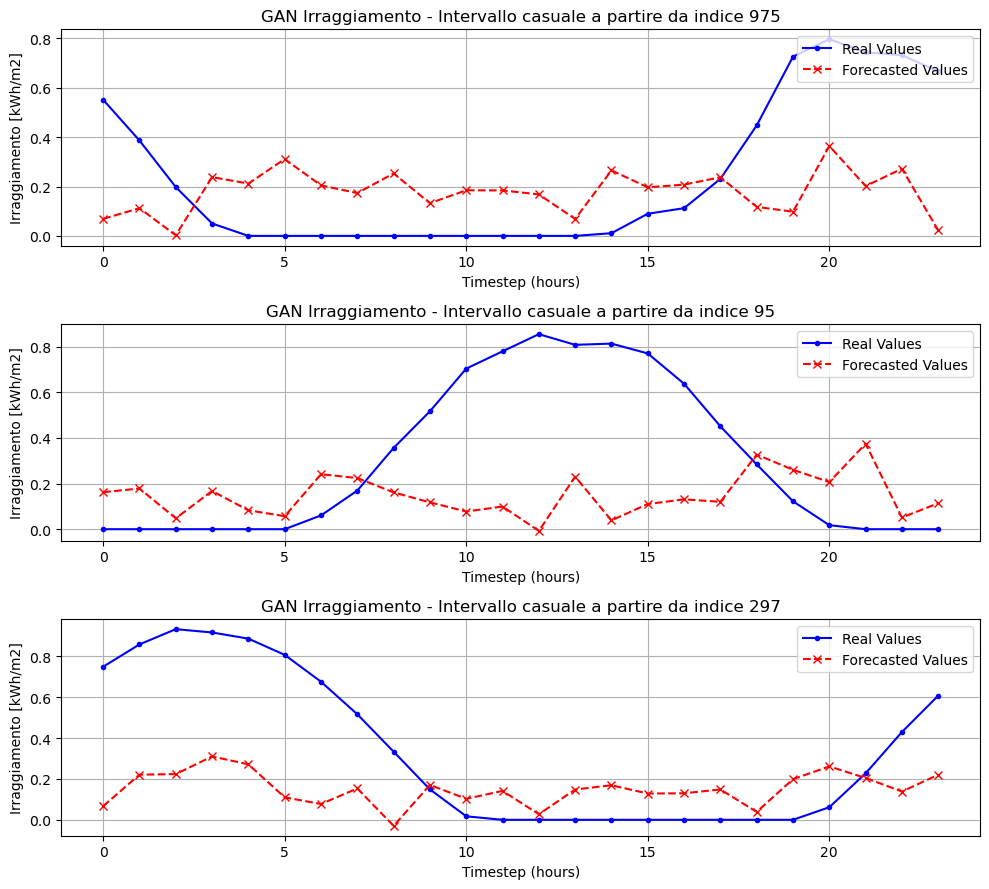

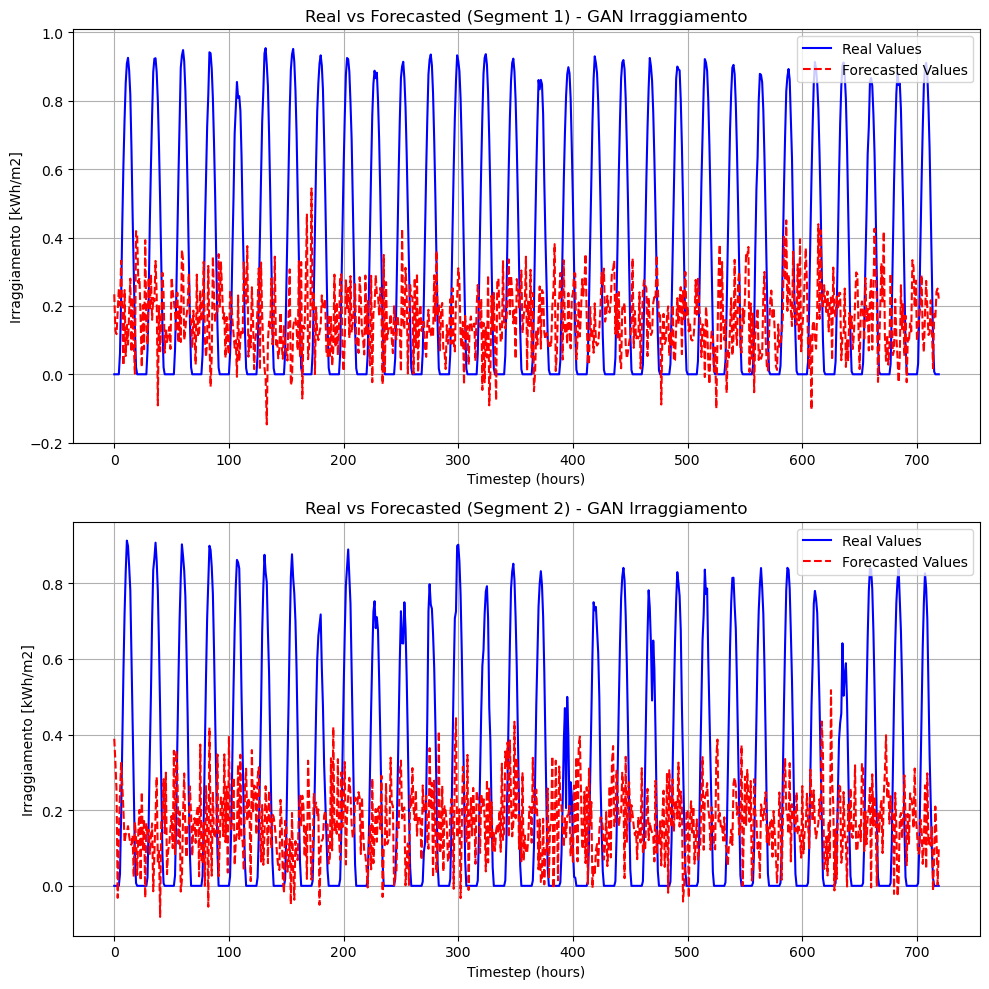

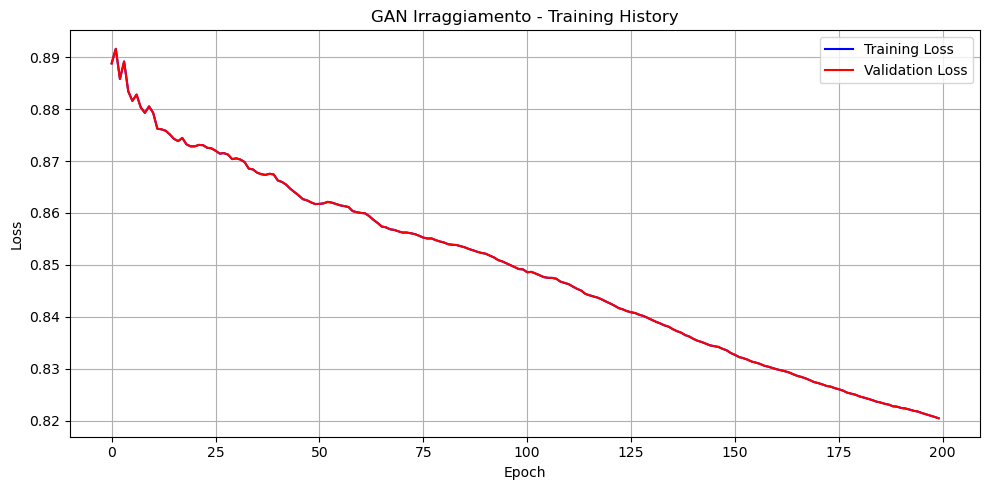

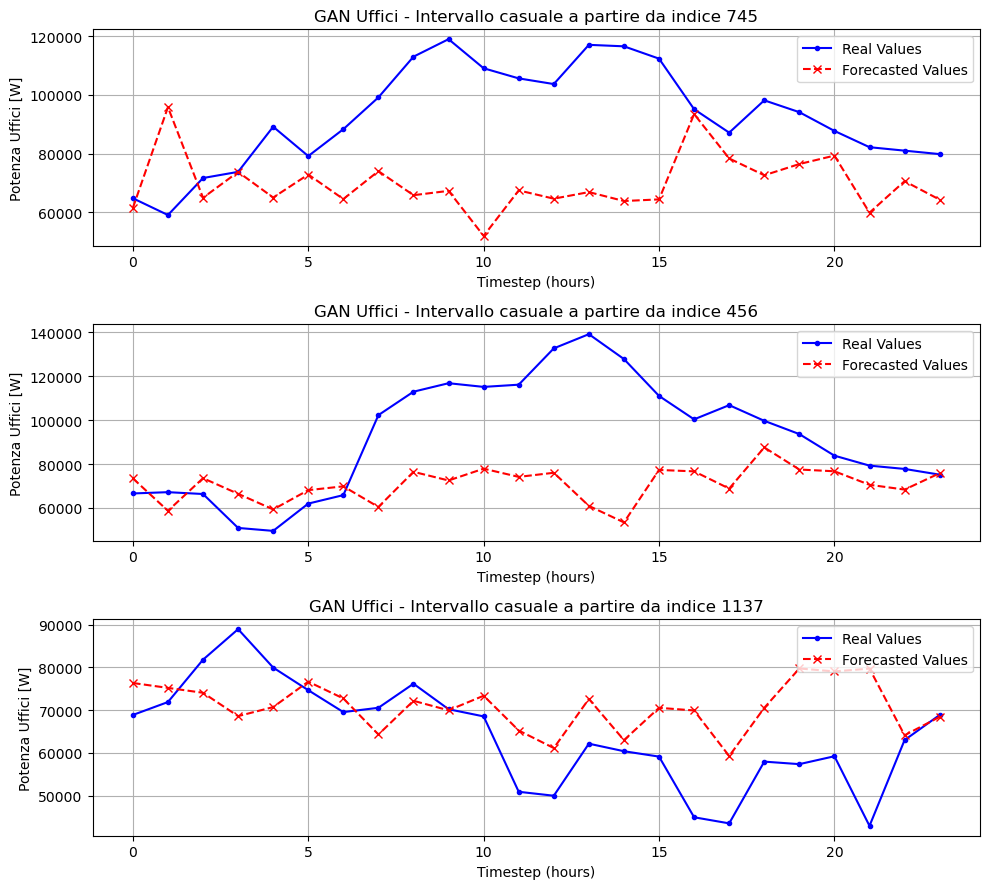

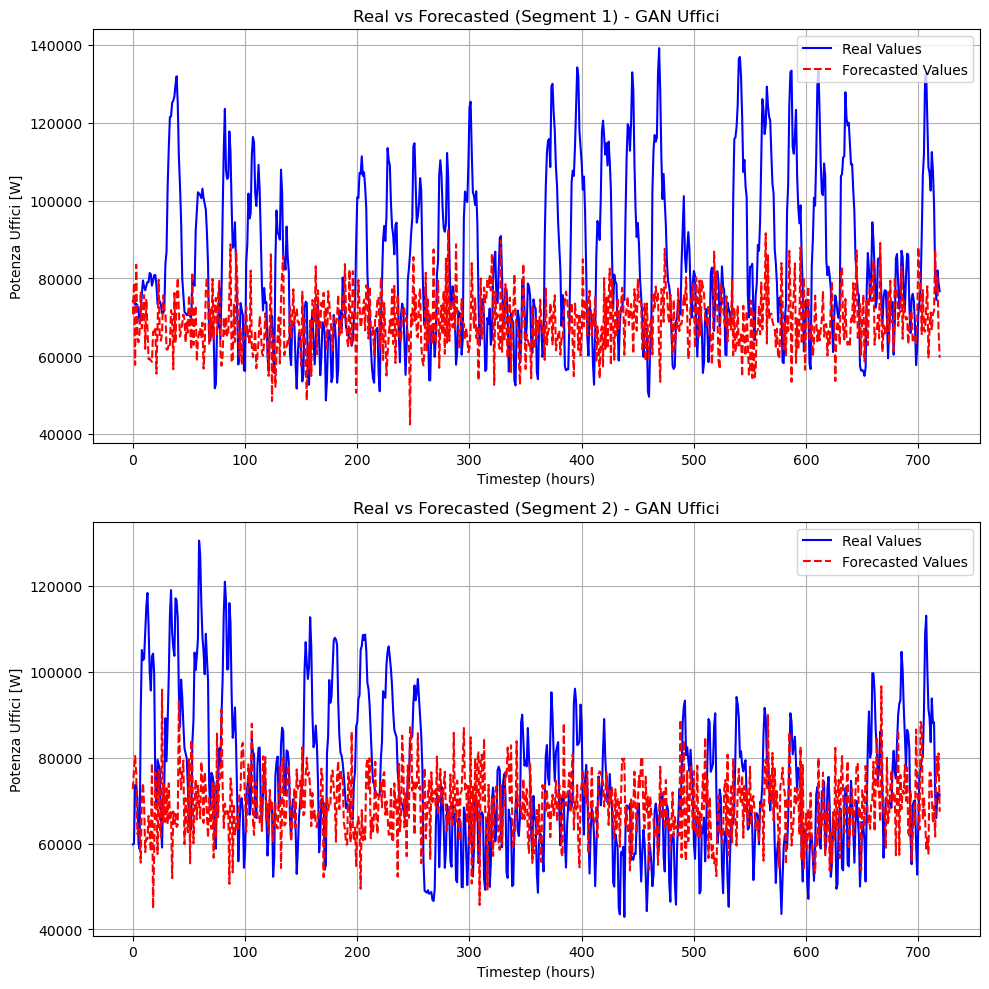

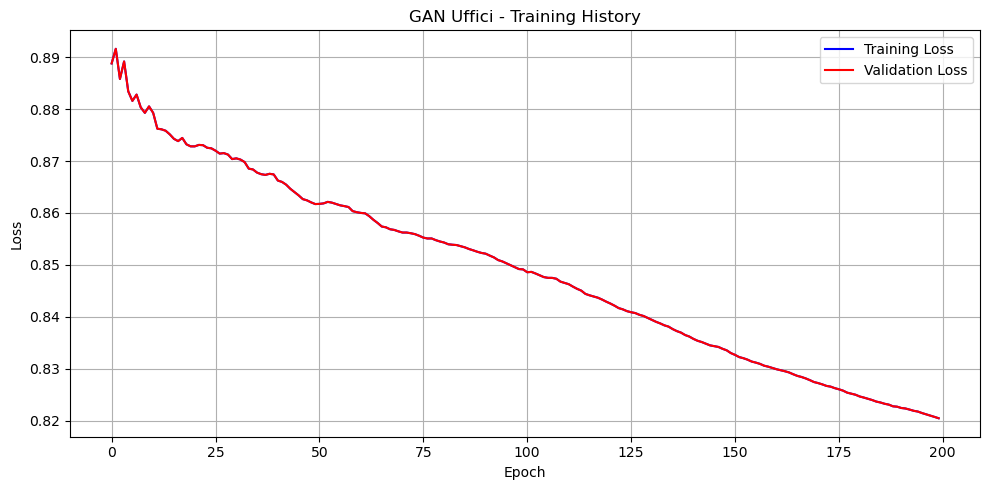

In [55]:
forecast_steps=1440

# Per "Irraggiamento"
target_irr = "Irraggiamento [kWh/m2]"
pred_std_irr_gan, pred_real_irr_gan = gan_autoregressive_inference(
    generator=generator,
    evaluation_data_std=evaluation_data_std,  # contiene tutte le 6 colonne
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_irr,
    train_mean=train_mean,
    train_std=train_std,
    noise_dim=noise_dim,
    output_filename="gan_irr_forecast.xlsx",
    model_name="GAN Irraggiamento",
    show_plots=True
)
gt_irr_real = evaluation_data.iloc[-1440:][target_irr].values

# Per "Potenza Uffici"
target_uff = "Potenza Uffici [W]"
pred_std_uff_gan, pred_real_uff_gan = gan_autoregressive_inference(
    generator=generator,
    evaluation_data_std=evaluation_data_std,
    features=features,
    input_width=input_width,
    forecast_steps=forecast_steps,
    target=target_uff,
    train_mean=train_mean,
    train_std=train_std,
    noise_dim=noise_dim,
    output_filename="gan_uff_forecast.xlsx",
    model_name="GAN Uffici",
    show_plots=True
)
gt_uff_real = evaluation_data.iloc[-1440:][target_uff].values

def compute_metrics_real(predictions_real, gt_real):
    """
    Calcola MAE e RMSE sui valori in scala reale.
    """
    mae = np.mean(np.abs(predictions_real - gt_real))
    rmse = np.sqrt(np.mean((predictions_real - gt_real) ** 2))
    return mae, rmse

mae_irr, rmse_irr = compute_metrics_real(pred_real_irr_gan, gt_irr_real)
mae_uff, rmse_uff = compute_metrics_real(pred_real_uff_gan, gt_uff_real)
print(f"GAN Irraggiamento - MAE: {mae_irr}, RMSE: {rmse_irr}")
print(f"GAN Uffici - MAE: {mae_uff}, RMSE: {rmse_uff}")


plotter_irr = Plotter(real_values=gt_irr_real, forecasted_values=pred_real_irr_gan,
                      xlabel="Timestep (hours)", ylabel="Irraggiamento [kWh/m2]",
                      model_name="GAN Irraggiamento", show_plot=True)
plotter_irr.test_plot(num_subplots=3)
plotter_irr.points_plot(num_subplots=2)
plotter_irr.history_plot(history)
# Per il modello "Potenza Uffici"
plotter_uff = Plotter(real_values=gt_uff_real, forecasted_values=pred_real_uff_gan,
                      xlabel="Timestep (hours)", ylabel="Potenza Uffici [W]",
                      model_name="GAN Uffici", show_plot=True)
plotter_uff.test_plot(num_subplots=3)
plotter_uff.points_plot(num_subplots=2)
plotter_uff.history_plot(history )

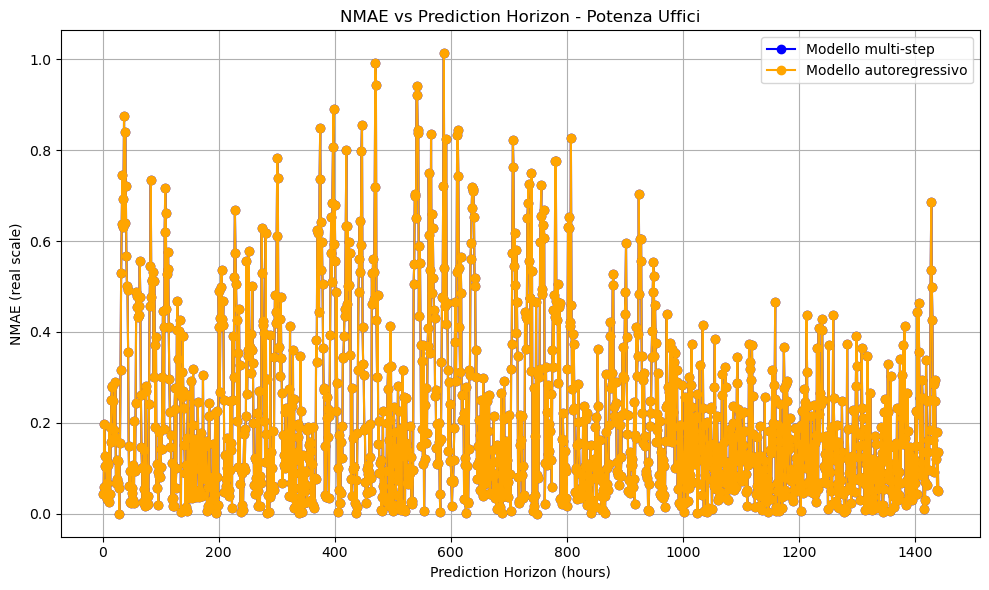

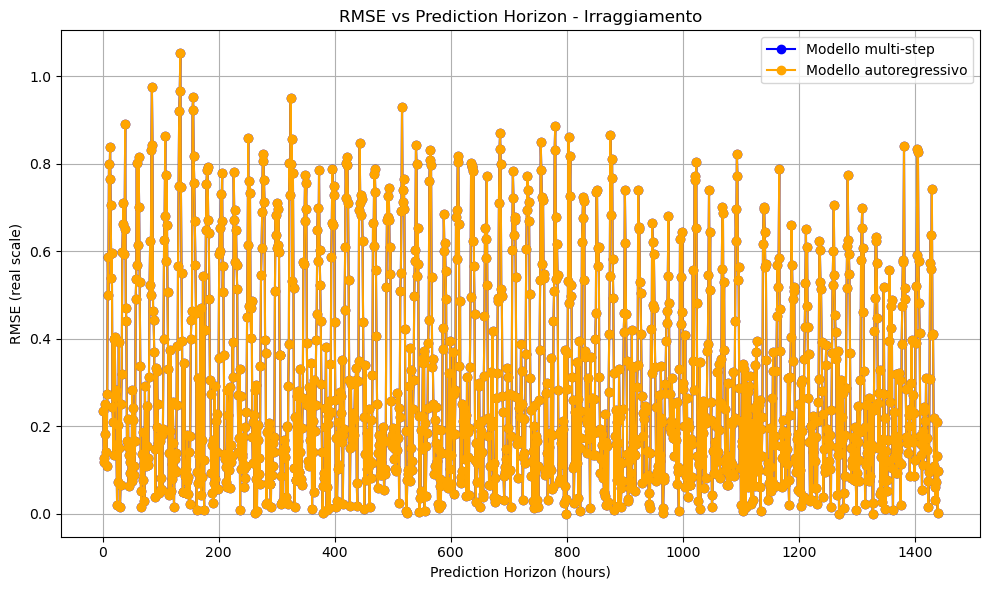

In [56]:

prediction_horizon = np.arange(1, forecast_steps+1)

# Per "Potenza Uffici": calcoliamo NMAE a ogni timestep
epsilon = 1e-6
nmae_uff = np.abs(pred_real_uff_gan - gt_uff_real)
mean_gt_uff = np.mean(np.abs(gt_uff_real))
nmae_uff_norm = nmae_uff / (mean_gt_uff + epsilon)

# Per "Irraggiamento": calcoliamo RMSE a ogni timestep (RMSE = |errore| per singolo valore)
rmse_irr_vals = np.abs(pred_real_irr_gan - gt_irr_real)

plotter_dummy = Plotter(real_values=[], forecasted_values=[], xlabel="Prediction Horizon (hours)",
                         ylabel="", model_name="Metriche GAN", show_plot=True)
plotter_dummy.plot_metrics(prediction_horizon, nmae_uff_norm, nmae_uff_norm, 
                           ylabel="NMAE (real scale)", 
                           title="NMAE vs Prediction Horizon - Potenza Uffici", 
                           filename="TimeSeries/plots/nmae_potenza_uffici_real.png")

plotter_dummy.plot_metrics(prediction_horizon, rmse_irr_vals, rmse_irr_vals, 
                           ylabel="RMSE (real scale)", 
                           title="RMSE vs Prediction Horizon - Irraggiamento", 
                           filename="TimeSeries/plots/rmse_irraggiamento_real.png")

In [57]:
# Creo un indice temporale a partire da "2022-07-01 00:00:00" con frequenza oraria, della stessa lunghezza dei forecast
time_index = pd.date_range(start="2022-07-01 00:00:00", periods=len(pred_real_uff_gan), freq="H")

# Creo e salvo il file Excel per pred_real_uff_gan
df_uff = pd.DataFrame({"timestep": time_index, "forecast": pred_real_uff_gan})
df_uff.to_excel("pred_real_uff_gan.xlsx", index=False)

# Creo e salvo il file Excel per pred_real_irr_gan
df_irr = pd.DataFrame({"timestep": time_index, "forecast": pred_real_irr_gan})
df_irr.to_excel("pred_real_irr_gan.xlsx", index=False)

/var/folders/fj/jf8_1bs122n5rv0h0w7bdgh00000gn/T/ipykernel_24161/3244233679.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start="2022-07-01 00:00:00", periods=len(pred_real_uff_gan), freq="H")
